In [ ]:
import pandas as pd
import requests
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
import time 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sb

In [195]:
def get_user_animelist(username: str, client_id: str):
    # Loads list of anime from MAL for a given user
    url = f'https://api.myanimelist.net/v2/users/{username}/animelist?limit=500'
    headers = {
        'X-MAL-CLIENT-ID': client_id
    }
    params = {
        'fields': 'id, title, list_status{score,status}, start_season{year}, mean, genres, popularity, media_type, rating, num_episodes, studios, num_list_users,favorites'
    }

    all_data = []
    next_page = url

    while next_page:
        response = requests.get(next_page, headers=headers, params=params if next_page == url else None)
        if response.status_code != 200:
            raise ValueError(f"Error with API request: {response.status_code} - {response.text}")

        data = response.json()
        all_data.extend(data['data'])
        next_page = data.get("paging", {}).get("next")

        print(f"Loaded {len(all_data)} anime...")

    return all_data

In [196]:
def to_dataframe(all_data):
    rows = []
    for item in all_data:
        anime = item['node']
        score = item.get('list_status', {}).get('score')
        status = item.get('list_status', {}).get('status')
        # num_episodes_watched = item.get('list_status', {}).get('num_episodes_watched')
        year = item.get('node', {}).get('start_season', {}).get('year')
        rows.append({
            "id": anime['id'],
            "title": anime['title'],
            "mean": anime.get('mean'),
            "genres": [g['name'] for g in anime.get('genres', [])],
            "studios": [s['name'] for s in anime.get('studios', [])],
            "rating": anime.get('rating'),
            "year": year,
            "type": anime.get('media_type'),
            "popularity": anime.get('popularity'),
            "score": score,
            "status": status,
            "members": anime['num_list_users'],
            "num_episodes": anime['num_episodes'],
        })
    
    df = pd.DataFrame(rows)
    df['studios'] = df['studios'].str.join(", ")
    df['genres'] = df['genres'].str.join(", ")

    return df

In [197]:
def comprehensive_evaluation(y_true, y_pred):
    """complex evaluation"""
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    accuracy_05 = np.mean(np.abs(y_true - y_pred) <= 0.5)
    accuracy_1 = np.mean(np.abs(y_true - y_pred) <= 1.0)
    accuracy_15 = np.mean(np.abs(y_true - y_pred) <= 1.5)
    
    score_metrics = {}
    for score in range(1, 11):
        mask = (y_true == score)
        if mask.sum() > 0:
            score_mae = mean_absolute_error(y_true[mask], y_pred[mask])
            score_metrics[f'MAE_score_{score}'] = score_mae
    
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    return {
        'MAE': mae,
        'MSE': mse, 
        'RMSE': rmse,
        'R2': r2,
        'Correlation': correlation,
        'Accuracy_±0.5': accuracy_05,
        'Accuracy_±1.0': accuracy_1,
        'Accuracy_±1.5': accuracy_15,
        **score_metrics
    }


In [198]:
import configparser

config = configparser.ConfigParser()
config.read('../config.ini')
USER_NAME = config.get('USER','USER_NAME').strip()
CLIENT_ID = config.get('USER','CLIENT_ID').strip()

In [199]:
data = get_user_animelist(USER_NAME, CLIENT_ID)

Loaded 500 anime...
Loaded 1000 anime...
Loaded 1500 anime...
Loaded 2000 anime...
Loaded 2500 anime...
Loaded 3000 anime...
Loaded 3500 anime...
Loaded 4000 anime...
Loaded 4500 anime...
Loaded 5000 anime...
Loaded 5054 anime...


In [200]:
df = to_dataframe(data)

In [201]:
df.tail(10)

,id,title,mean,genres,studios,rating,year,type,popularity,score,status,members,num_episodes
5044,3354,Zombie-Loan Specials,6.97,"Action, Horror, Shounen, Supernatural",XEBEC M2,pg_13,2008.0,special,4498,5,completed,29784,2
5045,37976,Zombieland Saga,7.50,"Award Winning, Comedy, Idols (Female), Music, ...",MAPPA,r,2018.0,tv,463,9,completed,523459,12
5046,50159,Zombieland Saga Movie: Yumeginga Paradise,NaN,"Comedy, Idols (Female), Music, Parody, Superna...",MAPPA,r,2025.0,movie,4244,0,plan_to_watch,33868,1
5047,40174,Zombieland Saga Revenge,7.99,"Comedy, Idols (Female), Music, Parody, Superna...",MAPPA,r,2021.0,tv,1163,8,completed,232665,12
5048,59421,Zutaboro Reijou wa Ane no Moto Konyakusha ni D...,7.36,"Drama, Josei, Romance",LandQ studios,pg_13,2025.0,tv,3615,5,completed,46248,12
5049,31245,Zutto Mae kara Suki deshita. Kokuhaku Jikkou I...,7.20,"Romance, School",Qualia Animation,pg_13,2016.0,movie,1076,5,completed,249713,1
5050,52034,[Oshi no Ko],8.56,"Award Winning, Drama, Reincarnation, Seinen, S...",Doga Kobo,pg_13,2023.0,tv,188,9,completed,983653,11
5051,55791,[Oshi no Ko] 2nd Season,8.55,"Drama, Reincarnation, Seinen, Showbiz",Doga Kobo,pg_13,2024.0,tv,532,8,completed,467947,13
5052,60058,[Oshi no Ko] 3rd Season,NaN,"Drama, Reincarnation, Seinen, Showbiz",Doga Kobo,pg_13,2026.0,tv,2074,0,plan_to_watch,117663,0
5053,1692,_Summer,5.55,"Drama, Harem, Romance",Rikuentai,pg_13,2006.0,ova,6682,2,completed,11199,2


In [202]:
df["studios"].replace(to_replace="", value="Unknown", inplace=True)
df["genres"].replace(to_replace="", value="Unknown", inplace=True)
df = df.dropna(subset=['score'])

C:\Users\dobre\AppData\Local\Temp\ipykernel_23600\87429005.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["studios"].replace(to_replace="", value="Unknown", inplace=True)
C:\Users\dobre\AppData\Local\Temp\ipykernel_23600\87429005.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [203]:
display(df["score"].value_counts().head(11))

score
0     1329
5      793
7      756
6      574
8      517
4      434
3      350
9      151
2      114
10      25
1       11
Name: count, dtype: int64

In [204]:
df.drop(columns=['title'], inplace=True)

In [205]:
df = df[df['score'] > 0].copy()
    
df['mean'] = df['mean'].fillna(df.groupby('type')['mean'].transform('median'))
    
categorical_cols = ['type', 'rating', 'status']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [206]:
df['year'] = df['year'].fillna(df['year'].mode()[0])
df['num_episodes'] = df['num_episodes'].fillna(df['num_episodes'].mode()[0])

In [207]:
df['popularity'] = df['popularity'].fillna(df['popularity'].median())

In [208]:
df['anime_age'] = 2025 - df['year']
df['anime_age'] = df['anime_age'].astype(int)
df.drop(columns=['year'], inplace=True)

In [209]:
df['log_members'] = np.log1p(df['members'])
df.drop(columns=['id', 'members'], inplace=True)

In [210]:
# Get dummy variables for each unique genre
genre_dummies = (
    df['genres']
    .str.split(', ', expand=True) 
    .stack()       
    .str.get_dummies()         
    .groupby(level=0)         
    .sum()                    
    .add_prefix('Genre_')  
)

df.drop(columns=['genres'], inplace=True)

In [211]:
df = pd.concat([df, genre_dummies], axis=1)

In [212]:
genre_columns = [col for col in df.columns if col.startswith('Genre_')]

genre_counts = df[genre_columns].sum().sort_values(ascending=False)
print(genre_counts)

Genre_Action         1480
Genre_Comedy         1335
Genre_Fantasy         996
Genre_School          918
Genre_Romance         871
                     ... 
Genre_Educational       6
Genre_Hentai            2
Genre_Boys Love         2
Genre_Erotica           2
Genre_Unknown           1
Length: 79, dtype: int64


In [213]:
top_genres = genre_counts.nlargest(40).index
antitop_genres = genre_counts.nsmallest(20).index

other_genres = [
    col for col in genre_columns
    if col not in top_genres and col not in antitop_genres
]

df['Genre_Rare'] = df[antitop_genres].max(axis=1)
df['Genre_Other'] = df[other_genres].max(axis=1)
df.drop(columns=other_genres, inplace=True)
df.drop(columns=antitop_genres, inplace=True)

In [214]:
type_dummies = pd.get_dummies(df['type'], prefix='Type')
df = pd.concat([df, type_dummies], axis=1)
df.drop(columns=['type'], inplace=True)

In [215]:
top_studios = df['studios'].value_counts().nlargest(10).index
print(top_studios)

Index(['J.C.Staff', 'A-1 Pictures', 'Madhouse', 'Studio Deen', 'Sunrise',
       'Production I.G', 'Bones', 'SILVER LINK.', 'Gonzo', 'Toei Animation'],
      dtype='object', name='studios')


In [216]:
df['studios'] = df['studios'].apply(lambda x: x if x in top_studios else 'Studios_Other')

In [217]:
studio_dummies = pd.get_dummies(df['studios'], prefix='Studios')
df = pd.concat([df, studio_dummies], axis=1)
df.drop(columns=['studios'], inplace=True)

In [218]:
rating_dummies = pd.get_dummies(df['rating'], prefix='Rating')
df = pd.concat([df, rating_dummies], axis=1)
df.drop(columns=['rating'], inplace=True)

In [219]:
status_dummies = pd.get_dummies(df['status'], prefix='Status')
df = pd.concat([df, status_dummies], axis=1)
df.drop(columns=['status'], inplace=True)

In [220]:
bool_cols = df.select_dtypes('bool').columns

df[bool_cols] = df[bool_cols].astype(int)

In [221]:
df.drop(columns=['Genre_Unknown'], inplace=True)

KeyError: "['Genre_Unknown'] not found in axis"

In [222]:
correlation = df['mean'].corr(df['score'])
print(correlation)

0.6884308880423077


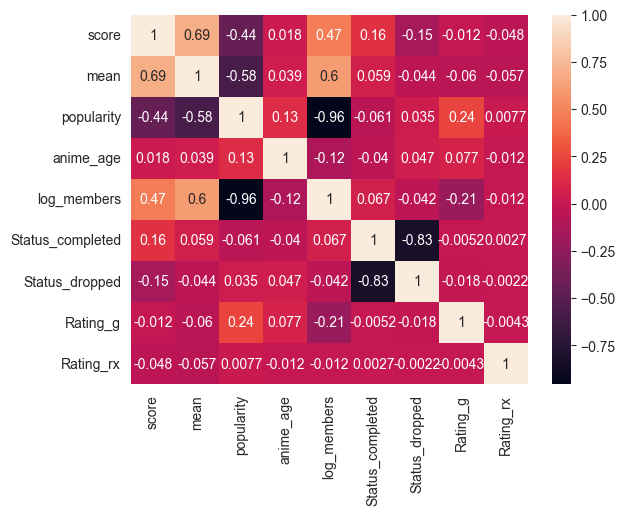

In [223]:
corr_cols = ['score', 'mean', 'popularity', 'anime_age', 
             'log_members', 
             'Status_completed', 'Status_dropped', 
             'Rating_g', 'Rating_rx']

corr_matrix = df[corr_cols].corr()
sb.heatmap(corr_matrix, annot=True)
plt.show()

In [224]:
corr_with_score = df.corr()['score']
high_corr_cols = corr_with_score[np.abs(corr_with_score) > 0.65].index
high_corr_cols = high_corr_cols.drop('score')
print(high_corr_cols)

Index(['mean'], dtype='object')


In [225]:
df.drop(columns=high_corr_cols, inplace=True)

In [226]:
df['num_episodes'] = np.log1p(df['num_episodes'])
df.drop(columns=['popularity'], inplace=True)

In [227]:
X = df.drop(columns=['score'])
y = df['score']

In [228]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [230]:
# balancing
sample_weights = compute_sample_weight('balanced', y_train.astype(int))

In [231]:
model_weighted = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, random_state=42 )
model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

RandomForestRegressor(min_samples_leaf=2, n_estimators=300, random_state=42)

In [232]:
y_pred_weight = model_weighted.predict(X_test)

In [233]:
print("Weighted")
results = comprehensive_evaluation(y_test, y_pred_weight)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

Weighted
MAE: 1.123
MSE: 1.950
RMSE: 1.396
R2: 0.401
Correlation: 0.636
Accuracy_±0.5: 0.271
Accuracy_±1.0: 0.505
Accuracy_±1.5: 0.715
MAE_score_1: 3.359
MAE_score_2: 2.023
MAE_score_3: 1.732
MAE_score_4: 1.071
MAE_score_5: 0.823
MAE_score_6: 0.875
MAE_score_7: 0.929
MAE_score_8: 1.388
MAE_score_9: 1.578
MAE_score_10: 1.386


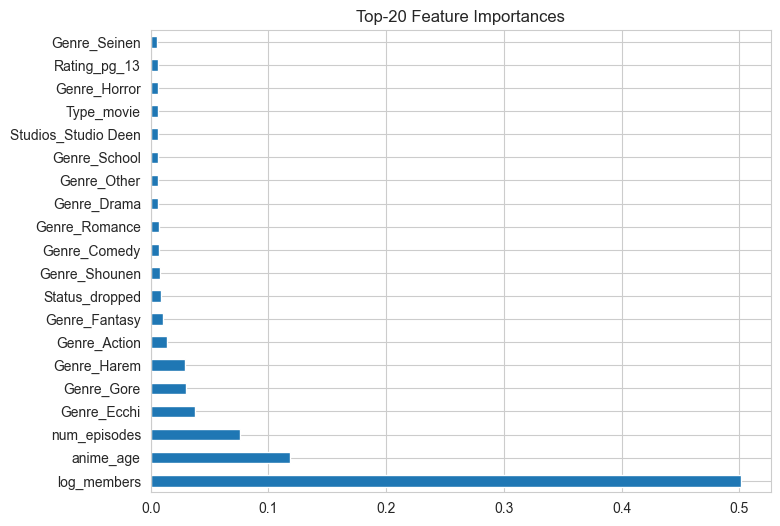

In [234]:
X = df.drop(columns=['score'])
importances = pd.Series(model_weighted.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='barh', figsize=(8,6))
plt.title("Top-20 Feature Importances")
plt.show()

In [241]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, sample_weight=sample_weights)
y_pred_cb = model.predict(X_test)


0:	learn: 2.8124701	test: 1.7979898	best: 1.7979898 (0)	total: 4.37ms	remaining: 4.37s
100:	learn: 1.3116403	test: 1.4950531	best: 1.4950531 (100)	total: 441ms	remaining: 3.92s
200:	learn: 1.1050521	test: 1.4331927	best: 1.4331927 (200)	total: 842ms	remaining: 3.35s
300:	learn: 0.9757510	test: 1.3954090	best: 1.3954090 (300)	total: 1.35s	remaining: 3.14s
400:	learn: 0.8924066	test: 1.3846906	best: 1.3840197 (395)	total: 2.04s	remaining: 3.04s
500:	learn: 0.8246347	test: 1.3777971	best: 1.3777255 (499)	total: 2.48s	remaining: 2.47s
600:	learn: 0.7800830	test: 1.3727688	best: 1.3727688 (600)	total: 2.93s	remaining: 1.95s
700:	learn: 0.7355701	test: 1.3692593	best: 1.3692593 (700)	total: 3.38s	remaining: 1.44s
800:	learn: 0.6942777	test: 1.3677429	best: 1.3673881 (781)	total: 3.81s	remaining: 946ms
900:	learn: 0.6572281	test: 1.3660554	best: 1.3659712 (891)	total: 4.4s	remaining: 483ms
999:	learn: 0.6234497	test: 1.3657239	best: 1.3649865 (957)	total: 5.33s	remaining: 0us

bestTest = 1.36

In [242]:
print("Catboost")
results = comprehensive_evaluation(y_test, y_pred_cb)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

Catboost
MAE: 1.075
MSE: 1.863
RMSE: 1.365
R2: 0.428
Correlation: 0.668
Accuracy_±0.5: 0.302
Accuracy_±1.0: 0.540
Accuracy_±1.5: 0.738
MAE_score_1: 3.461
MAE_score_2: 1.740
MAE_score_3: 1.488
MAE_score_4: 0.959
MAE_score_5: 0.862
MAE_score_6: 0.925
MAE_score_7: 0.997
MAE_score_8: 1.240
MAE_score_9: 1.307
MAE_score_10: 1.048
